# neural network for multiclass classification

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import torch
from torch import nn 

cuda
torch.Size([1000]) torch.Size([1000])


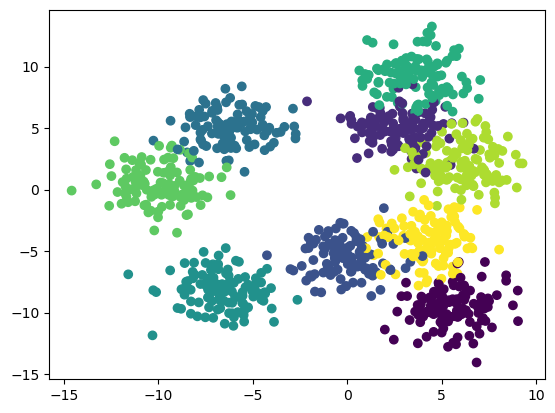

In [105]:
N_SAMPLES = 1000
N_CENTERS = 9
RANDOM_SEED = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

X_blob, y_blob = make_blobs(n_samples=N_SAMPLES,
                              centers=N_CENTERS,
                              cluster_std=1.5,
                              random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

TEST_SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(X_blob,
                                                    y_blob,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_SEED)

X_train, X_test, y_train, y_test = X_train.to(DEVICE), X_test.to(DEVICE), y_train.to(DEVICE), y_test.to(DEVICE)

print(X_blob[:, 0].size(), y_blob.size())

plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob)
plt.show()

In [106]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=32):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)
    
model = BlobModel(2, N_CENTERS, 32).to(DEVICE)
model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=9, bias=True)
  )
)

In [107]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

In [108]:
model.eval()
with torch.inference_mode():
    logits  = model(X_test)

print(logits)

y_preds = torch.softmax(logits, dim=1)
print(y_preds)

tensor([[-0.2331,  0.1304, -0.3599,  ...,  0.6931, -0.3650, -0.0917],
        [ 0.2093, -0.0700,  0.3827,  ..., -0.0602,  0.0320,  0.4015],
        [ 0.5301,  1.0524, -0.0632,  ..., -0.5998,  0.2611, -0.0260],
        ...,
        [-0.1630,  0.0476, -0.1024,  ...,  0.5530, -0.1954, -0.4131],
        [-0.2559,  0.0897, -0.2476,  ...,  0.3434, -0.1053, -0.2403],
        [-0.0672,  0.8618, -0.0116,  ..., -0.2148,  0.4291, -0.2256]],
       device='cuda:0')
tensor([[0.0840, 0.1208, 0.0740,  ..., 0.2120, 0.0736, 0.0967],
        [0.1291, 0.0976, 0.1535,  ..., 0.0986, 0.1081, 0.1564],
        [0.1612, 0.2717, 0.0890,  ..., 0.0521, 0.1232, 0.0924],
        ...,
        [0.0934, 0.1153, 0.0993,  ..., 0.1912, 0.0905, 0.0728],
        [0.0886, 0.1252, 0.0893,  ..., 0.1613, 0.1030, 0.0900],
        [0.0931, 0.2358, 0.0985,  ..., 0.0804, 0.1530, 0.0795]],
       device='cuda:0')


In [109]:
def acc_fun(y_true, y_preds):
    correct = torch.eq(y_true, y_preds).sum().item()
    acc = (correct / len(y_preds)) * 100 
    return acc

### traingin loop

In [110]:
epochs = 2000
torch.manual_seed(42)
for epoch in range(epochs):
    model.train()
    
    logits = model(X_train)
    y_preds = torch.softmax(logits, dim=1).argmax(dim=1)
    
    loss = loss_fn(logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.inference_mode():
        logits = model(X_test)
        y_preds = torch.softmax(logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(logits, y_test)
        test_acc = acc_fun(y_test, y_preds)
        
        if epoch % 25 == 0:
            print(f"{epoch} | {loss} | {test_loss} | {test_acc}")


0 | 2.5642833709716797 | 2.481490135192871 | 1.0


25 | 1.6099129915237427 | 1.585868239402771 | 49.5
50 | 1.0570317506790161 | 1.0471030473709106 | 63.0
75 | 0.7322814464569092 | 0.7207666635513306 | 72.0
100 | 0.5590978860855103 | 0.5474229454994202 | 80.5
125 | 0.464740514755249 | 0.4528633952140808 | 85.0
150 | 0.40824535489082336 | 0.3940357267856598 | 85.5
175 | 0.37064194679260254 | 0.3547521233558655 | 87.0
200 | 0.34137558937072754 | 0.325149804353714 | 89.0
225 | 0.31466978788375854 | 0.2998743951320648 | 88.5
250 | 0.2879489064216614 | 0.2759431302547455 | 91.0
275 | 0.2645080089569092 | 0.2543739676475525 | 92.0
300 | 0.2435459941625595 | 0.2355727255344391 | 92.5
325 | 0.2248300313949585 | 0.21910114586353302 | 93.0
350 | 0.20864981412887573 | 0.20502324402332306 | 94.0
375 | 0.1950819045305252 | 0.1929667890071869 | 94.0
400 | 0.1840890645980835 | 0.1829988658428192 | 94.0
425 | 0.17516914010047913 | 0.1748948097229004 | 94.0
450 | 0.16808336973190308 | 0.1684168428182602 | 94.0
475 | 0.16241508722305298 | 0.1631064563989

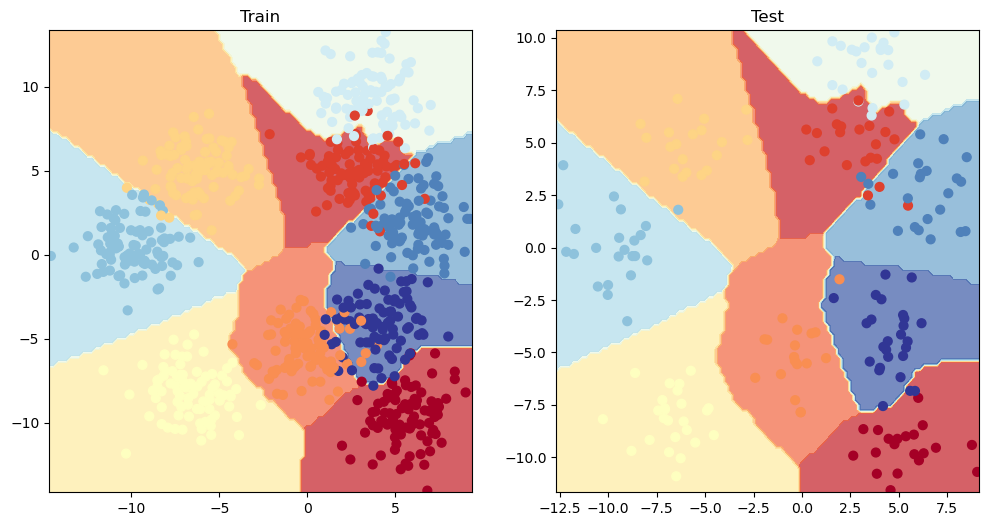

In [113]:
from helper_functions import plot_predictions, plot_decision_boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)
plt.show()